### This is a tutorial to create simple two-galaxy blends with the [DESC Weak Lensing Deblending Package](http://weaklensingdeblending.readthedocs.io/en/latest/index.html)(hereafter WLD), analyze the images with the LSST DM stack, and then develop metrics on the output.

The tutorial is intended to run on v14.0 of the LSST Science Pipeline installed on version w.2017.46 of [Shared Stack @NERSC](https://confluence.slac.stanford.edu/display/~heather/Shared+Stack+@NERSC). 


The aim of the tutorial is to use a simple two-galaxy blend to let the user develop intuition for how blending is affected by the individual galaxy parameters and to demonstrate the errors and complications in measurement that arise due to blending.


Tutorial is divided into two parts. 
1. Create a two-galaxy blend of your choice and run DM on it. 
1. Analyze the output from WLDeb package and DM stack on a pre-made catalog of different two-galaxy blends.

## Part A: Create a two-galaxy blend of your choice and run DM on it. 

The user can execute `run()` command to create two-galaxy blends on the fly. To create images but not run the DM stack, execute `run(run_DM=False)`.

`run()` involves three main scripts:

#### 1) Make a  catsim-like catalog with two-galaxy blends ( `make_catalog.py `)
We make a catsim-like galaxy catalog with two entries:a central galaxy and a secondary galaxy. Central galaxy is located at the center of the field and its parametrs are fixed. Secondary galaxy parameters are inputs that can be varied to get different types of blends.

Description of catalog parameters available [here](http://weaklensingdeblending.readthedocs.io/en/latest/catalog.html)

In [ ]:
import numpy as np
from astropy.table import Table, Column
from scipy import spatial
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import fitsio
import sys
# add path to where WeakLensingDeblending/ is installed
sys.path.insert(0, 'WeakLensingDeblending/')
import descwl
import os
import scipy.ndimage
import galsim
import math

plt.rc('image', origin='lower',
       interpolation='none')
plt.rc('figure.subplot', wspace=0.3)
plt.rc('figure.subplot', hspace=0.3)

In [20]:
% run make_catalog.py --help


usage: make_catalog.py [-h] [--flux_frac FLUX_FRAC] [--bhlr_frac BHLR_FRAC]
                       [--dhlr_frac DHLR_FRAC] [--x0 X0] [--y0 Y0]
                       [--p_angle P_ANGLE] [--b_e B_E] [--d_e D_E]
                       [--path PATH]

optional arguments:
  -h, --help            show this help message and exit
  --flux_frac FLUX_FRAC
                        Flux of second galaxy as a fraction of central galaxy
                        flux [Default:1]
  --bhlr_frac BHLR_FRAC
                        HLR of second galaxy bulge as a fraction of central
                        galaxy bulge HLR [Default:1]
  --dhlr_frac DHLR_FRAC
                        HLR of second galaxy disk as a fraction of central
                        galaxy disk HLR [Default:1]
  --x0 X0               x coordinate of center of second galaxy in pixels.
                        Center of central galaxy is (0,0).[Default:10]
  --y0 Y0               y coordinate of center of second galaxy in pixels.
        

In [21]:
# Catsim-like catalog output from make_catalog.py
Table.read('data/gal_pair_catalog.fits', format='fits')

galtileid,ra,dec,redshift,fluxnorm_bulge,fluxnorm_disk,fluxnorm_agn,a_b,a_d,b_b,b_d,pa_bulge,pa_disk,u_ab,g_ab,r_ab,i_ab,z_ab,y_ab
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,0.0,0.0,1.7503708601,1.40949004364e-19,2.28364400463e-17,0.0,0.170293092728,0.948550999165,0.158227205276,0.703664124012,54.5641593933,54.5641593933,23.2031650543,23.2069988251,23.2974529266,23.2564220428,23.1560020447,23.036901474
1,0.000555555555556,0.000277777777778,1.7503708601,1.05711753273e-19,1.71273300347e-17,0.0,0.164149322692,0.8169830524,0.164149322692,0.8169830524,0.0,0.0,23.5155118958,23.5193456666,23.6097997681,23.5687688843,23.4683488862,23.3492483155


####  2) Run [WLD](http://weaklensingdeblending.readthedocs.io/en/latest/index.html) 
WeakLensingDeblending is a python package for perfoming fast pixel-level simulations of weak-lensing survey images, measuring pixel-level observables (SNR, shear, ...) and analyzing the effects of overlapping sources.

Catsim-like catalog from above is provided as input to WLDeb package to create an output fits file.
- The primary HDU contains the final simulated image using double precision floats. All sources are superimposed and fluxes are given in units of detected electrons for the full exposure time.
- HDU[1] contains a binary table where each row represents one simulated source and the columns are source parameters

Description of package output available [here](http://weaklensingdeblending.readthedocs.io/en/latest/output.html)

In [22]:
%run WeakLensingDeblending/simulate.py --help



usage: simulate.py [-h] [--verbose] [--survey-defaults] [--memory-trace]
                   [--alpha ALPHA] [--no-hsm] [--add-lmfit] [--add-noise]
                   [--catalog-name NAME] [--ra-center RA] [--dec-center DEC]
                   [--only-id ID] [--skip-id ID] [--star-catalog-name NAME]
                   [--only-star-id ID] [--survey-name {LSST,DES,CFHT,HSC}]
                   [--filter-band {u,g,r,i,z,y}] [--image-width W]
                   [--image-height H] [--pixel-scale S] [--exposure-time T]
                   [--zero-point s0] [--mirror-diameter D]
                   [--effective-area A] [--zenith-psf-fwhm FWHM]
                   [--atmospheric-psf-beta BETA] [--atmospheric-psf-e1 E1]
                   [--atmospheric-psf-e2 E2] [--sky-brightness B]
                   [--airmass X] [--extinction k] [--cosmic-shear-g1 G1]
                   [--cosmic-shear-g2 G2] [--no-disk] [--no-bulge] [--no-agn]
                   [--verbose-model] [--verbose-star-model] [--min

In [23]:
# Output Table from WLDeb package
Table.read('data/gal_pair_wldeb.fits', format='fits', hdu=1)

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
0,1,2,1,1,97,127,96,128,0.993866,0.00613425,0.0,0.0,1.75037,23.2564,0.0410309,354306.0,0.850114,0.87072,-0.038242,0.149943,0.993632,0.727325,0.910258,1.05703,0.982172,54.809,54.4475,54.4464,32.9035,32.5109,0.0342625,0.0279298,0.0290795,0.0346686,0.0280514,0.0290888,0.72612,-0.0736376,0.288902,0.0,0.0,256.569,-0.000670803,-0.000104145,0.00032761,-9.66193e-13,2.84011e-12,257.195,-0.000677217,-0.000101467,0.000329485,-5.9544e-07,-2.93163e-06
1,1,2,0,1,12,252,115,145,0.993866,0.00613425,4.0,3.6,1.75037,21.509,0.0410309,1.77153e+06,4.20319,9.05988,0.803434,0.016297,12.7373,1.38701,0.0101407,4.40068,0.994715,101.305,100.821,100.821,58.9538,58.5425,0.0170391,0.0140738,0.00310806,0.0171705,0.0141887,0.00311865,1.92529,0.975928,0.0198009,0.0,0.0,385.305,-0.000110841,0.000230331,2.29398e-06,-3.55449e-12,6.74669e-13,314.793,-0.000149584,0.000266392,-4.93762e-06,7.35445e-05,2.29128e-05


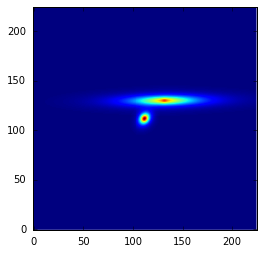

In [19]:
# Output Image from WLDeb package
wldeb_image = fitsio.read('data/gal_pair_wldeb.fits',ext=0)
plt.imshow(wldeb_image)

####  3) Run LSST DM stack on image (`process( )` module below) 

We use the following lsst root packages:
- `afw`:    Provides core LSST utility classes including geometric shapes, images, source detection, convolution and high-level exposure objects.
- `meas`:   Algorithms focused on processing individual sources in an image, including PSF modeling, WCS fitting, and source detection, deblending, and measurement.


The image is input as LSST `Exposure` class represented by a `MaskedImage` (that is comprised of an image, a mask and a variance image) and the PSF.  The mask is set to None for this tutorial.

We run DM Detection(` lsst.meas.algorithms.SourceDetectionTask`), Deblending (`lsst.meas.deblender.SourceDeblendTask`) and Measurement(`lsst.meas.base.SingleFrameMeasurementConfig`) on **one single image**. There is **no** PSF estimation, coadding images, or multi-band images in this tutorial. We provide the stack the true PSF and variance image as input. 

##### Detection:
In each band, the image is smoothened, then above-threshold regions (Footprints) are detected. Within each Footprint, one or more Peaks are found. Footprint is a critical component of LSST’s detection algorithm, as it is used to represent an above-threshold region in an image (similar to SExtractor’s “segmentation map”). A Footprint describes a pixelized region as a sequence of Spans, each of which holds the y position and minimum and maximum x positions.

##### Deblending


A “family” to refer to group of blended objects, and “child” to refer to a particular deblended object within a family. A “parent” is also created for each family, representing the alternate hypothesis that the blend is actually a single object. Blends may be hierarchical; a child at one level may be a parent at the level below. For each parent, `deblend_nChild` gives the number of children an object has.

Outputs of the deblender are HeavyFootprints, which are Footprints that hold the pixel values of the deblended children. 

![alt text](https://www.spiedigitallibrary.org/ContentImages/Proceedings/9913/99130G/FigureImages/00092_psisdg9913_99130g_page_5_2.jpg "Heavy Footprint")

##### Measurement
When source parameters for a child are measured, the pixel values in the Footprint of all other children are replaced with noise values.

All quantities in the catalogs are measured for both parent and child. 

Helpful links:
[SDSS deblender](http://www.sdss3.org/dr8/algorithms/deblend.php)
[Stack with astropy](https://docushare.lsstcorp.org/docushare/dsweb/Get/Publication-113/)
[LSST Data Management Code Overview presentation](https://zenodo.org/record/48434)



In [ ]:
def setup_stack(hsm=False,min_pix=1,bkg_bin_size=32,thr_value=5):
    """
    Function to setup the DM stack
    
    Args:
    -----
    
    hsm : bool, If True it activates the HSM shape measurement algorithm
    from the stack. This algorithm is not included by default so make sure
    that is installed before activating (default=False).
    
    min_pix: Minimum size in pixels of a source to be considered by the
    stack (default=1).
    
    bkg_bin_size: Binning of the local background in pixels (default=32).
    
    thr_value: SNR threshold for the detected sources to be included in the
    final catalog.
    """
    import lsst.afw.table
    import lsst.afw.image
    import lsst.afw.math
    import lsst.meas.algorithms
    import lsst.meas.base
    import lsst.meas.deblender
    import numpy as np
    import astropy.io.fits as fits
    import descwl
    import astropy.table
    import scipy.spatial
    import scipy.ndimage
    from lsst.sims.GalSimInterface.wcsUtils import tanSipWcsFromDetector
    from lsst.sims.GalSimInterface import LSSTCameraWrapper
    from lsst.sims.utils import ObservationMetaData
    schema = lsst.afw.table.SourceTable.makeMinimalSchema()
    config1 = lsst.meas.algorithms.SourceDetectionConfig()
    # Tweaks in the configuration that can improve detection
    # Change carefully!
    #####
    config1.tempLocalBackground.binSize=bkg_bin_size # This changes the local background binning. The default is 32 pixels
    config1.minPixels=min_pix # This changes the minimum size of a source. The default is 1
    config1.thresholdValue=thr_value # This changes the detection threshold for the footprint (5 is the default)
    #####
    detect = lsst.meas.algorithms.SourceDetectionTask(schema=schema, config=config1)
    deblend = lsst.meas.deblender.SourceDeblendTask(schema=schema)
    config1 = lsst.meas.base.SingleFrameMeasurementConfig()
    ## HSM is not included in the stack by default. You have to download it and activate it.
    if hsm:
        import lsst.meas.extensions.shapeHSM
        config1.plugins.names.add('ext_shapeHSM_HsmShapeBj')
        config1.plugins.names.add('ext_shapeHSM_HsmShapeLinear')
        config1.plugins.names.add('ext_shapeHSM_HsmShapeKsb')
        config1.plugins.names.add('ext_shapeHSM_HsmShapeRegauss')
        config1.plugins.names.add('ext_shapeHSM_HsmSourceMoments')
        config1.plugins.names.add('ext_shapeHSM_HsmPsfMoments')
    measure = lsst.meas.base.SingleFrameMeasurementTask(schema=schema, config=config1)
    camera_wrapper = LSSTCameraWrapper()
    obs = ObservationMetaData(pointingRA=0, pointingDec=0,
                          boundType='circle', boundLength=2.0,
                          mjd=52000.0, rotSkyPos=0,
                          bandpassName='i')
    
def process(input_path, output_path=None, seed=123):
    LSST_i = descwl.output.Reader(input_path).results # We read the image using descwl's package
    LSST_i.add_noise(noise_seed=seed) # We add noise
    image = lsst.afw.image.ImageF(LSST_i.survey.image.array) # We translate the image to be stack-readable
    sky_magnitude = LSST_i.survey.sky_brightness + LSST_i.survey.extinction*(LSST_i.survey.airmass -1.2)
    sky_counts = LSST_i.survey.exposure_time*LSST_i.survey.zero_point*10**(-0.4*(sky_magnitude-24))*LSST_i.survey.pixel_scale**2
    variance_array = LSST_i.survey.image.array+sky_counts # We generate a variance array
    variance = lsst.afw.image.ImageF(variance_array) # Generate the variance image
    masked_image = lsst.afw.image.MaskedImageF(image, None, variance) # Generate a masked image, i.e., an image+mask+variance image (with mask=None)
    psf_array = LSST_i.survey.psf_image.array # We read the PSF image from the package
    psf_array = psf_array.astype(np.float64) 
    psf_new = scipy.ndimage.zoom(psf_array,zoom=75/76.) # We have to rescale to have odd dimensions
    im = lsst.afw.image.ImageD(psf_new) # Convert to stack's format
    fkernel = lsst.afw.math.FixedKernel(im) 
    psf = lsst.meas.algorithms.KernelPsf(fkernel) # Create the kernel in the stack's format
    exposure = lsst.afw.image.ExposureF(masked_image) # Passing the image to the stack
    exposure.setPsf(psf) # Assign the exposure the PSF that we created
    wcs_in = tanSipWcsFromDetector('R:2,2 S:1,1',camera_wrapper,obs,2000) # We generate a WCS
    exposure.setWcs(wcs_in) # And assign it to the exposure
    table = lsst.afw.table.SourceTable.make(schema)  # this is really just a factory for records, not a table
    detect_result = detect.run(table, exposure) # We run the stack (the detection task)
    catalog = detect_result.sources   # this is the actual catalog, but most of it's still empty
    deblend.run(exposure, catalog) # run the deblending task
    measure.run(catalog, exposure) # run the measuring task
    catalog = catalog.copy(deep=True)
    if output_path is not None:
        catalog.writeFits(output_path) #write a copy of the catalog
    return catalog, masked_image # We return a catalog object

In [8]:
# Output Table from DM stack
Table.read('data/gal_pair_dm.fits', format='fits', hdu=1)

flags [72],id,coord_ra,coord_dec,parent,deblend_nChild,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psfFlux,base_GaussianCentroid_x,base_GaussianCentroid_y,base_NaiveCentroid_x,base_NaiveCentroid_y,base_SdssCentroid_x,base_SdssCentroid_y,base_SdssCentroid_xSigma,base_SdssCentroid_ySigma,base_Blendedness_old,base_Blendedness_raw_flux,base_Blendedness_raw_flux_child,base_Blendedness_raw_flux_parent,base_Blendedness_abs_flux,base_Blendedness_abs_flux_child,base_Blendedness_abs_flux_parent,base_Blendedness_raw_child_xx,base_Blendedness_raw_child_yy,base_Blendedness_raw_child_xy,base_Blendedness_raw_parent_xx,base_Blendedness_raw_parent_yy,base_Blendedness_raw_parent_xy,base_Blendedness_abs_child_xx,base_Blendedness_abs_child_yy,base_Blendedness_abs_child_xy,base_Blendedness_abs_parent_xx,base_Blendedness_abs_parent_yy,base_Blendedness_abs_parent_xy,base_SdssShape_xx,base_SdssShape_yy,base_SdssShape_xy,base_SdssShape_xxSigma,base_SdssShape_yySigma,base_SdssShape_xySigma,base_SdssShape_x,base_SdssShape_y,base_SdssShape_flux,base_SdssShape_fluxSigma,base_SdssShape_psf_xx,base_SdssShape_psf_yy,base_SdssShape_psf_xy,base_SdssShape_flux_xx_Cov,base_SdssShape_flux_yy_Cov,base_SdssShape_flux_xy_Cov,base_CircularApertureFlux_3_0_flux,base_CircularApertureFlux_3_0_fluxSigma,base_CircularApertureFlux_4_5_flux,base_CircularApertureFlux_4_5_fluxSigma,base_CircularApertureFlux_6_0_flux,base_CircularApertureFlux_6_0_fluxSigma,base_CircularApertureFlux_9_0_flux,base_CircularApertureFlux_9_0_fluxSigma,base_CircularApertureFlux_12_0_flux,base_CircularApertureFlux_12_0_fluxSigma,base_CircularApertureFlux_17_0_flux,base_CircularApertureFlux_17_0_fluxSigma,base_CircularApertureFlux_25_0_flux,base_CircularApertureFlux_25_0_fluxSigma,base_CircularApertureFlux_35_0_flux,base_CircularApertureFlux_35_0_fluxSigma,base_CircularApertureFlux_50_0_flux,base_CircularApertureFlux_50_0_fluxSigma,base_CircularApertureFlux_70_0_flux,base_CircularApertureFlux_70_0_fluxSigma,base_GaussianFlux_flux,base_GaussianFlux_fluxSigma,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_Variance_value,footprint
,,rad,rad,,,pix,pix,,pix,pix,pix,pix,pix,pix,pix,pix,,,ct,ct,,ct,ct,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix2,pix,pix,ct,ct,pix2,pix2,pix2,ct pix2,ct pix2,ct pix2,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,ct,,
bool,int64,float64,float64,int64,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32
False .. False,1,nan,nan,0,7,nan,nan,nan,111.975728836,112.00929242,111.038156349,112.023267256,111.949741401,112.055653841,0.0268184,0.0289899,0.0,0.0,331000.682051,331000.682051,nan,nan,nan,15.2030720814,18.6518312552,3.89123235252,15.2030720814,18.6518312552,3.89123235252,nan,nan,nan,nan,nan,nan,15.3252600159,19.0577560468,4.00523444288,0.112431,0.091057,0.139814,111.964821915,112.074602254,335072.378329,1229.09687142,3.00234545712,3.00234545712,2.03022634366e-09,-69.0942,-18.0577,-85.9222,86957.2890625,287.549957275,155450.234375,389.924713135,212817.65625,458.309234619,295352.40625,542.478759766,348969.830565,590.736684628,448399.275337,669.626220616,851045.313101,922.521172169,1256313.49032,1120.85391123,1619382.30531,1272.54952961,1800203.90247,1341.71677431,335072.378329,870.421505063,125409.321098,389.215966559,2.70613050461,1
False .. False,2,nan,nan,1,0,nan,nan,nan,111.974188049,111.883350637,110.987675465,111.052754554,111.938718202,111.894885852,0.0268249,0.0275126,0.00463838556702

### Output from `run( )`
- Deblended images for each child
- #### WLDEb Output:
  - `snr_isof`: S/N ratio calculated by including signal variance and correlations with fit parameters for this source in the sky-dominated limit
  - `snr_grpf`: S/N ratio calculated by including signal + overlap variance and correlations with fit parameters for all sources in the sky-dominated limit
  - `Purity`: Purity of this source in the range 0-1 (equals 1 when grp_size is 1)
$$purity = \frac{\sum_p s_{ip}\cdot s_{ip}}{\sum_p (s_{ip}\cdot \sum_j s_{jp})} $$
where the sums over $p$ are over all pixels within the overlapping group and the sum over $j$ is over all sources with any overlap with source $i$, including $i$ itself. Purity is then a ratio of weighted flux estimates over pixels where we treat the object as being isolated in the numerator and include overlaps in the denominator, and use the true profile of source $i$ for the weights in both cases. 
By construction, $0 < purity \le 1$ with $ purity = 1$ for perfectly isolated sources.
- #### DM Output
  - flux: `base_SdssShape_flux`, flux measured with  matched elliptical Gaussian weights
  - Blendedness parameter: name= `base_Blendedness_old`, "blendedness from dot products:(child.dot(parent)/child.dot(child) - 1)"  
$$Blendedness = \frac{\sum_p (s_{ip}\cdot \sum_j s_{jp})} {\sum_p s_{ip}\cdot s_{ip}} - 1 $$
sum over $j$ is over all sources with any overlap with source $i$,*NOT* including $i$ itself

$$purity = 1/(1 + Blendedness)$$


In [94]:
def get_deblended_images(catalog, masked_image):
    """Gets heavy footprint for each child and returns 
    a list of the deblended images, each centered to their position
    in the masked image and padded with 0 to match
    the masked image shape.
    """
    deb_images = []
    shape = masked_image.array.shape
    for record in catalog:
        # get HeavyFootprint image for each catalog entry
        hfpt = get_hfpt(record, masked_image)
        box=hfpt.getBBox()
        hfpt_image = lsst.afw.image.ImageF(box)
        hfpt.insert(hfpt_image)
        # center and padding to match masked image
        before_0, after_0 = box.getBeginY(), shape[0] - box.getEndY()
        before_1, after_1 = box.getBeginX(), shape[1] - box.getEndX()
        im_temp = np.lib.pad(hfpt_image.array, ((before_0, after_0), (before_1, after_1)),
                             'constant')
        # im_temp_galsim = galsim.Image(im_temp, scale=0.2)
        # generator = galsim.random.BaseDeviate(seed=wldeb.noise_seed*100)
        # noise = galsim.PoissonNoise(rng=generator, sky_level=wldeb.survey.mean_sky_level)
        #im_temp_galsim.addNoise(noise)
        # deb_images.append(im_temp_galsim.array)
        deb_images.append(im_tempy)
    return deb_images
        
def get_hfpt(record, masked_image):
    """Gets Heavy footprint of a particular catalog object.
    HeavyFootprint is produced only for objects detected as 
    blends by DM. So for isolated object the footprint is 
    converted to heavy footprint. This essentially returns all the
    pixels in masked image corresponding to the footprint.
    """
    fpt = record.getFootprint()
    if fpt.isHeavy() is False:
        return lsst.afw.detection.makeHeavyFootprint(fpt, masked_image)
    return fpt

def run_dm_stack(input_path, output_path, run_DM, min_pix=min_pix,
                 bkg_bin_size=bkg_bin_size, thr_value=thr_value, seed=123):
    """Runns DM stack and returns deblended images"""
    if run_DM is False:
        wldeb = descwl.output.Reader(input_path).results # We read the image using descwl's package
        wldeb.add_noise(noise_seed=seed) # We add noise
        return wldeb.survey.image.array , []  
    print ("Running DM stack")
    setup_stack(hsm=False, min_pix=min_pix,
                bkg_bin_size=bkg_bin_size, thr_value=thr_value)
    
    catalog, masked_image = process(input_path, output_path=output_path,
                                    seed=seed)
    children = catalog[(catalog['deblend_nChild']==0)]
    deb_img = get_deblended_images(children,  wldeb, masked_image)
    return masked_image.image.array, deb_img # We return a catalog object

def print_vals(cat1, cat2):
    lab1=["purity", "base_SdssShape_flux"]
    lab2 = ["purity", "flux" ]
    disp_labels =['Purity', "Flux"]
    extra = ["snr_grpf", "snr_isof"]
    for i in range(len(lab1)):
        if cat1:
            val1 = f"{cat1[lab1[i]]:.2f}"
        else:
            val1=" - "
        if cat2:
            v = cat2[lab2[i]]
            val2 = f"{v:.2f}"
        else:
            val2=" - "
        display([val1, val2], disp_labels[i])
    if cat2:
        for i in range(len(extra)):
            v = cat2[extra[i]]
            display([' - ', f"{v:.2f}"], extra[i])
                 
def display(vals, name):
    print ("{0:<12} {1:<25} {2:>26}".format(name,vals[0], vals[1]))

def get_match(tru_cat, det_cat,
              im_shape, tolerance=5):
    """Returns index of true catalog that are the closest 
    match to the detected catalog centers within the tolerance
    limit.
    """
    z1 = np.zeros((len(tru_cat),2)) 
    z1[:,0] = np.array(tru_cat['dx']/0.2 + (im_shape[1]-1)/2.)
    z1[:,1] = np.array(tru_cat['dy']/0.2 + (im_shape[0]-1)/2.)
    z1_tree = spatial.KDTree(z1)
    z2 = np.zeros((len(det_cat),2)) 
    z2[:,0] = det_cat['base_GaussianCentroid_x']
    z2[:,1] = det_cat['base_GaussianCentroid_y']
    match = z1_tree.query(z2, distance_upper_bound=tolerance)
    return match

def plot_gals(images, label,vmax, vmin,
              xmin, xmax, ymin, ymax):
    """Makes subplot of the input images"""
    plt.figure(figsize=[18,12])
    third_plot = True
    cat_labels =[": DM", ": WLDeb", "True - Obs" ]
    for i in range(2):
        plt.subplot(3, 3, i+1)
        if np.any(images[i]):
            plt.imshow(images[i][ymin:ymax, xmin:xmax],
                       vmin=vmin,vmax=vmax)
            plt.title(label + cat_labels[i])
            plt.colorbar(label='Counts')
            if i==0:
                mask = [images[i] == 0.]
        else:
            third_plot = False
    if third_plot:
        plt.subplot(3, 3, 3)
        diff = images[0] - images[1]
        diff[mask] = 0
        plt.imshow(diff[ymin:ymax, xmin:xmax],
                   vmin=-vmax*0.5,vmax=vmax*0.5,
                   cmap=plt.get_cmap('bwr'))
        plt.title("Obs - True")
        plt.colorbar(label='Counts')
    plt.show()

def plot_ellipses(im_blend, deb_imgs_blend, im_blend_no_noise, vmax, vmin,
                  x0, y0,xmin, xmax, ymin, ymax, run_DM):
    """Makes subplot of true image, sum of deblended image and their
    difference. The true image is """
    fig = plt.figure(figsize=[16,10])
    ax1 = fig.add_subplot(441)
    ax1.imshow(im_blend[ymin:ymax, xmin:xmax],
               vmin=vmin,vmax=vmax)
    if run_DM:
        ax2 = plt.subplot(442, sharey=ax1)
        deb_imgs_blend_sum = np.sum(deb_imgs_blend, axis=0)
        im2 = ax2.imshow(deb_imgs_blend_sum[ymin:ymax, xmin:xmax],
                    vmin=vmin,vmax=vmax)
        ax2.set_title("Sum of Heavy Footprints")
        fig.colorbar(label='Counts', ax=ax2, mappable=im2)
        mask = [deb_imgs_blend_sum == 0.]
        ax3 = plt.subplot(443)
        diff = im_blend_no_noise
        diff[mask] = 0
        print(np.sum(diff))
        im3 = ax3.imshow(diff[ymin:ymax, xmin:xmax],
                   vmin=-vmax*0.5,vmax=vmax*0.5,
                   cmap=plt.get_cmap('bwr'))
        ax3.set_title("True no noise outside footprint")
        fig.colorbar(label='Counts', ax=ax3, mappable=im3)
    plt.show()

def run(flux_frac=0.75, bhlr_frac=1, dhlr_frac=1,
        x0=10, y0=5, p_angle=0, b_e=0, d_e=0.,
        band='i', exp=5520, run_DM=True,
        min_pix=1, bkg_bin_size=32, thr_value=5):  
    g1, g2 = 0.0, 0.0 # input shear
    im_h, im_w = 425, 425 # image size
    x_size, y_size = 85, 85 # Number of pixels to display 
    in_all, out_all = data_dir + 'gal_pair_catalog.fits', data_dir + 'gal_pair_wldeb.fits'
    in1, in2 = data_dir + 'gal1_catalog.fits', data_dir + 'gal2_catalog.fits'
    out1, out2 = data_dir + 'gal1_wldeb.fits', data_dir + 'gal2_wldeb.fits'
    dm_out_all = data_dir + 'gal_pair_dm.fits'
    dm_out1, dm_out2 = data_dir + 'gal1_dm.fits', data_dir + 'gal2_dm.fits'
    if (np.abs(x0) > 20 or (np.abs(y0) > 20)):
        print (" galaxy near stamp edge: Select |x0|<=20 and |y0|<=20 ")
        return
    if flux_frac <= 0:
        print (" flux_frac must be positive ")
        return
    % run make_catalog.py --flux_frac $flux_frac --bhlr_frac $bhlr_frac --dhlr_frac $dhlr_frac \
         --x0 $x0 --y0 $y0 --p_angle $p_angle --b_e $b_e --d_e $d_e --path $data_dir
    %run WeakLensingDeblending/simulate.py --catalog-name $in_all --output-name $out_all \
        --image-width $im_w --image-height $im_h --no-stamps --filter-band $band --exposure-time $exp \
        --calculate-bias --cosmic-shear-g1 $g1 --cosmic-shear-g2 $g2
    %run WeakLensingDeblending/simulate.py --catalog-name $in1 --output-name $out1 \
        --image-width $im_w --image-height $im_h --no-stamps --filter-band $band --exposure-time $exp \
        --calculate-bias --cosmic-shear-g1 $g1 --cosmic-shear-g2 $g2
    %run WeakLensingDeblending/simulate.py --catalog-name $in2 --output-name $out2 \
        --image-width $im_w --image-height $im_h --no-stamps --filter-band $band --exposure-time $exp \
        --calculate-bias --cosmic-shear-g1 $g1 --cosmic-shear-g2 $g2
    cat_wl = Table.read(out_all, format='fits', hdu=1)
    cat_wl1 = Table.read(out1, format='fits', hdu=1)
    cat_wl2 = Table.read(out2, format='fits', hdu=1)
    cat_wls = [cat_wl1, cat_wl1]
    im_blend, deb_imgs_blend = run_dm_stack(out_all, dm_out_all, min_pix=min_pix,
                                  bkg_bin_size=bkg_bin_size, thr_value=thr_value, run_DM)
    im1, deb_imgs1 = run_dm_stack(out1, dm_out1, min_pix=min_pix,
                                  bkg_bin_size=bkg_bin_size, thr_value=thr_value, run_DM=False)
    im2, deb_imgs2 = run_dm_stack(out2, dm_out2, min_pix=min_pix,
                                  bkg_bin_size=bkg_bin_size, thr_value=thr_value, run_DM=False)
    im_blend_no_noise = fitsio.read(out_all, ext=0)
    images = [im1, im2]
    if run_DM is True:
        cat = Table.read(dm_out_all,
                         format='fits', hdu=1)
        dm_cat_blend = cat[cat['deblend_nChild']==0]
        cat = Table.read(dm_out1,
                         format='fits', hdu=1)
        cat1 = cat[cat['deblend_nChild']==0]
        cat = Table.read(dm_out2,
                         format='fits', hdu=1)
        cat2 = cat[cat['deblend_nChild']==0]
        purity = 1/(1 + dm_cat_blend['base_Blendedness_old'])
        col = Column(purity, name="purity")
        dm_cat_blend.add_column(col)
        dm_catalogs = [cat1, cat2]
        match = get_match(cat_wl, dm_cat_blend,im_blend.shape)
        num = len(dm_cat_blend)
        print ("Number of children detected by DM", num)
        print (f"Total Flux in input {np.sum(im_blend)} ")
        print (f"Total Flux in children {np.sum(deb_imgs_blend)} ")
    else:
        match = [np.array([np.nan, np.nan]),
                 np.array([0, 1])]
        num = 2
        print ("Not running DM")
        print ("Number of true galaxies", num) 
    xmin, xmax = int((im_w - x_size)/2), int(im_w - (im_w - x_size)/2 )
    ymin, ymax = int((im_h - y_size)/2), int(im_h - (im_h - y_size)/2)
    vmax, vmin = im_blend.max() * 0.8, -10  
    # Plot blend
    plot_ellipses(im_blend,deb_imgs_blend, im_blend_no_noise, vmax, vmin,
                  x0,y0,xmin, xmax, ymin, ymax, run_DM)
    # Plot individual galaxies
    labels = ['Central Galaxy', "Second Galaxy"]
    for i in range(num):
        if np.isinf(match[0][i]):
            plot_gals([deb_imgs_blend[i], None], 'Spurious Detection', vmax, vmin,
                      xmin, xmax, ymin, ymax)
            print ("Spurious Detection\n")
            print_vals(dm_cat_blend[i], None)
            print("\n\n")
        elif np.isnan(match[0][i]):
            plot_gals([None, images[match[1][i]]], labels[match[1][i]], vmax, vmin,
                      xmin, xmax, ymin, ymax)
            print_vals(None, cat_wl[match[1][i]])
        else:
            if num==1:
                plot_gals([im_blend, images[match[1][i]] ], labels[match[1][i]], vmax, vmin,
                          xmin, xmax, ymin, ymax)
                print_vals(dm_cat_blend[i], cat_wl[match[1][i]])
                undet_indx = int((match[1][i] + 1)%2)
                plot_gals([im_blend, images[undet_indx]], 'Undetected Object', vmax, vmin,
                          xmin, xmax, ymin, ymax)
                print_vals(None, cat_wl[undet_indx])
            else:
                plot_gals([deb_imgs_blend[i], images[match[1][i]] ], labels[match[1][i]], vmax, vmin,
                          xmin, xmax, ymin, ymax)
                print_vals(dm_cat_blend[i], cat_wl[match[1][i]])

In [ ]:
data_dir = 'data/'
# If not running stack, set this to False
run_DM = True

Running DM stack
Number of children detected by DM 2
Total Flux in input 616240.5 
Total Flux in children 567944.0 
-48296.5


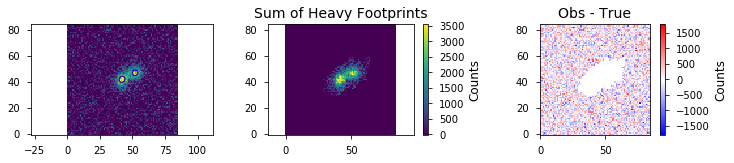

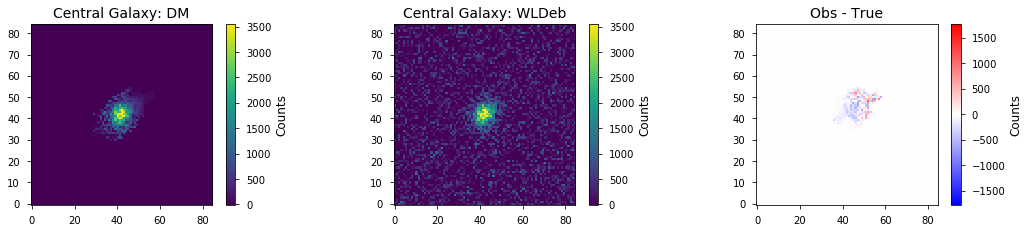

Purity       0.84                                            0.88
Flux         276257.62                                  354306.22
snr_grpf      -                                             22.50
snr_isof      -                                             32.90


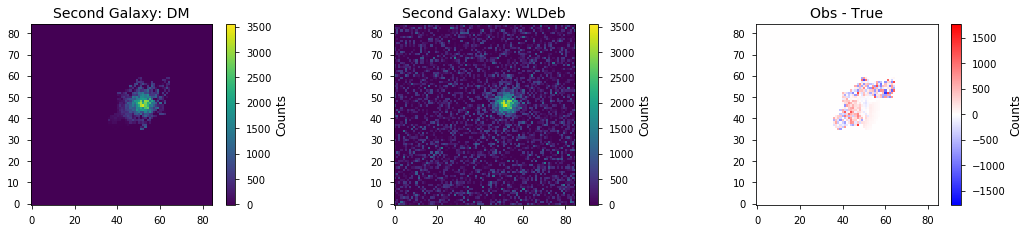

Purity       0.79                                            0.80
Flux         253224.40                                  265729.66
snr_grpf      -                                             16.87
snr_isof      -                                             24.74


In [95]:
# Input parameters with their default values:
# flux_frac=0.75, bhlr_frac=1, dhlr_frac=1,
# x0=10, y0=5, p_angle=0, b_e=0, d_e=0.,
# band='i', exp=5520
run(run_DM=run_DM)

## Exercise:
Q) How does exsposure time affect deblender?

In [ ]:
# Default exposure time exp=5520s 
run(run_DM=run_DM, exp=30)

## Exercise:
Q) Does the deblender conserve flux?

Running DM stack
Number of children detected by DM 2
Total Flux in input 1757981.5 
Total Flux in children 1695782.5 
-62199.0


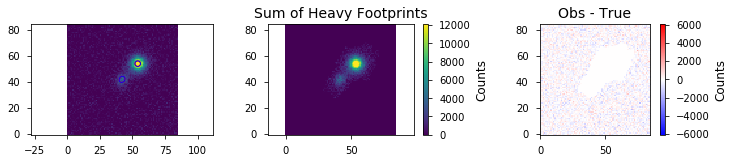

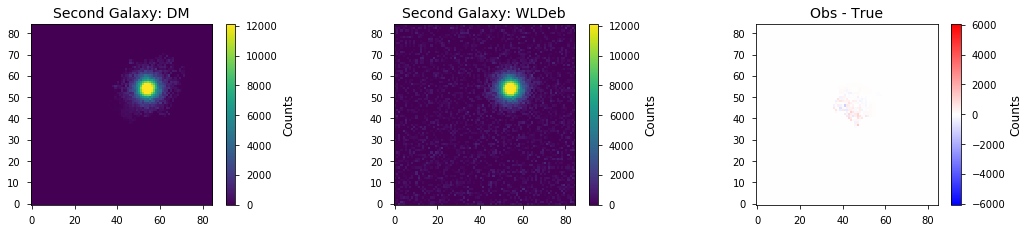

Purity       0.99                                            0.99
Flux         1235014.66                                1417224.88
snr_grpf      -                                            121.76
snr_isof      -                                            131.55


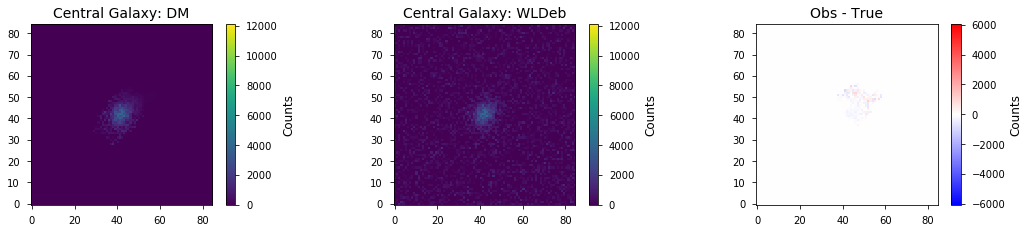

Purity       0.85                                            0.85
Flux         291133.22                                  354306.22
snr_grpf      -                                             30.16
snr_isof      -                                             32.90


In [98]:
run(x0=12, y0=12, flux_frac=4, d_e=0, p_angle=180, run_DM=run_DM)

Running DM stack
Number of children detected by DM 9
Total Flux in input 2071415.5 
Total Flux in children 1740364.5 
-331051.0


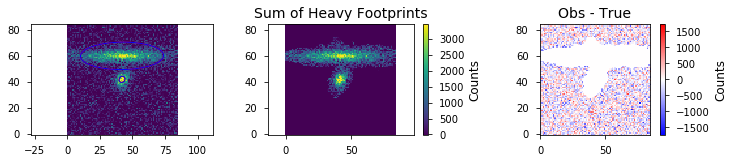

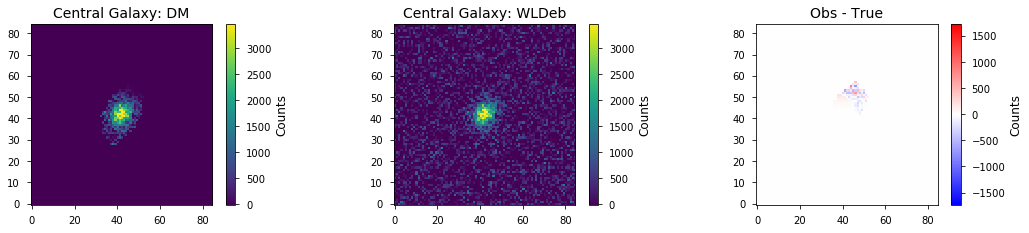

Purity       0.99                                            0.98
Flux         295237.19                                  354306.22
snr_grpf      -                                             32.45
snr_isof      -                                             32.90


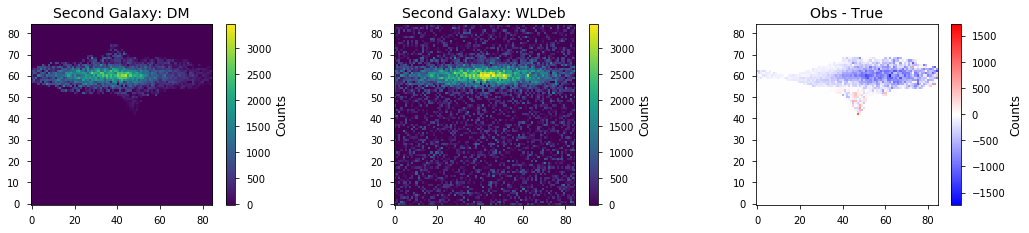

Purity       0.78                                            0.99
Flux         958557.81                                 1771531.12
snr_grpf      -                                             58.54
snr_isof      -                                             58.95


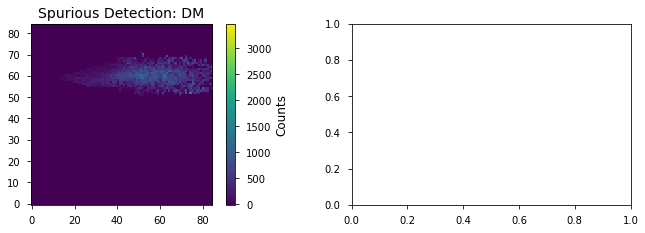

Spurious Detection

Purity       0.40                                              - 
Flux         393075.55                                         - 





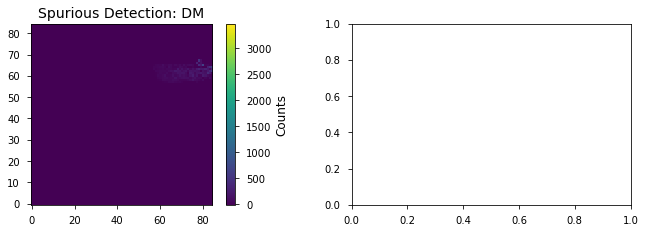

Spurious Detection

Purity       0.38                                              - 
Flux         163621.23                                         - 





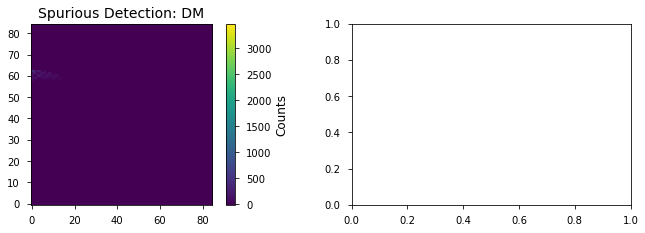

Spurious Detection

Purity       0.73                                              - 
Flux         nan                                               - 





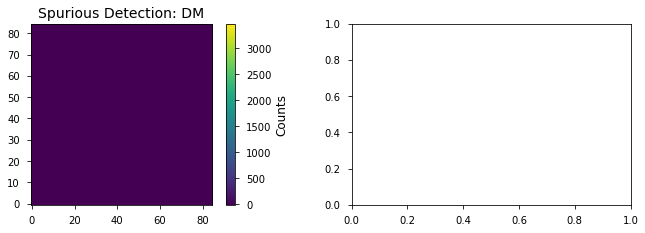

Spurious Detection

Purity       0.62                                              - 
Flux         nan                                               - 





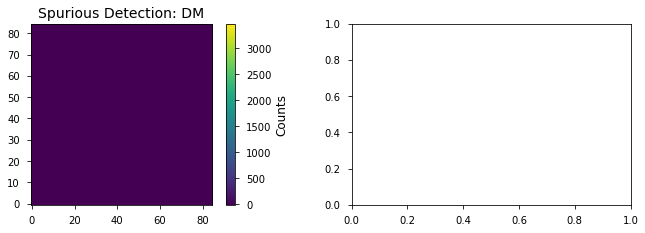

Spurious Detection

Purity       0.68                                              - 
Flux         nan                                               - 





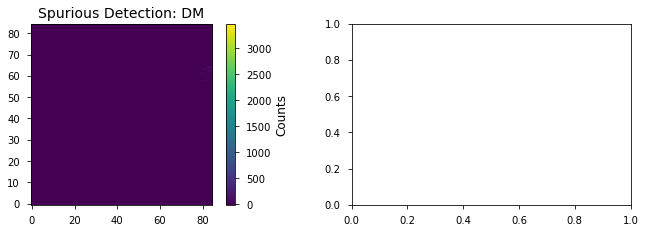

Spurious Detection

Purity       0.57                                              - 
Flux         nan                                               - 





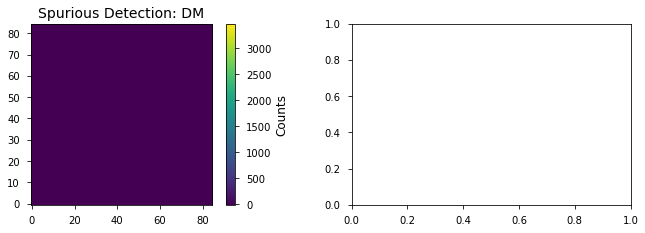

Spurious Detection

Purity       0.53                                              - 
Flux         nan                                               - 





In [97]:
run(x0=0, y0=18, flux_frac=5, d_e=0.8, p_angle=180, run_DM=run_DM)

## Exercise:
Q) Construct 3 galaxy pairs in such a so as to make one of the galaxies undetected by DM? Can you guess before running which galaxy will be undetected?

In [ ]:
run(run_DM=run_DM)

## Exercise:
Q) Construct a galaxy pair that produces spurious detection by DM.

In [ ]:
run(run_DM=run_DM)